# Types d'organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [5]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\Users\\rroll\\Documents\\GitHub\\2HS2179_militants-pour-la-paix\\notebooksJupyter\\network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [4]:
## define SPARQL enpoint
endpoint = "https://ag132kz7jrzck2hf.allegrograph.cloud/repositories/peace/sparql"

In [5]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/Raphix93/2HS2179_militants-pour-la-paix/blob/main/wikidata/graph/imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


679
[['http://www.wikidata.org/entity/Q133281500',
  'Christina Gibb',
  '1929',
  'employment',
  'http://www.wikidata.org/entity/Q17509124',
  'Chilton Saint James School',
  '3',
  'combined school | private school | secondary school'],
 ['http://www.wikidata.org/entity/Q133281500',
  'Christina Gibb',
  '1929',
  'employment',
  'http://www.wikidata.org/entity/Q1150437',
  'Victoria University of Wellington',
  '1',
  'public university'],
 ['http://www.wikidata.org/entity/Q133734026',
  'Henning Zierock',
  '1951',
  'membership',
  'http://www.wikidata.org/entity/Q133734335',
  'Society Culture of Peace',
  '1',
  'peace organization']]


## Inspect the data


In [7]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  679


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q20266330,Frederick William University Berlin,1,university
11,http://www.wikidata.org/entity/Q105840219,Gwyn Kirk,1945,membership,http://www.wikidata.org/entity/Q5604092,Greenham Common Women's Peace Camp,1,peace camp
12,http://www.wikidata.org/entity/Q105876,Horst-Eberhard Richter,1923,employment,http://www.wikidata.org/entity/Q165980,University of Vienna,1,university


### Distribution of relationships in relation to birthYears of organisations members

In [9]:
l_50 = list(range(1800, 2000, 50))
print(l_50)

[1800, 1850, 1900, 1950]


In [10]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1800, 1830, 1860, 1890, 1920, 1950, 1980, 2010]

In [11]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [12]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [13]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q2154954,Vegetarian Society,2,charitable organization | club,1851-1880
5,http://www.wikidata.org/entity/Q105301557,Sofia Spångberg,1898,membership,http://www.wikidata.org/entity/Q105317493,Q105317493,1,voluntary association,1881-1910
10,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q20266330,Frederick William University Berlin,1,university,1881-1910


In [14]:
df_p.to_csv('data/persons_organisations_from_organisations.csv', index=False, encoding='utf-8')


#### Reload from CSV

This is only possible if you already stored the data into a CSV, cf. below

In [14]:
### load from CSV

file_add = 'data/persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

679


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q1233784,Inner Temple,3,educational institution | inns of court | univ...,1860-1889,"['educational institution', 'inns of court', '..."
1,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q2154954,Vegetarian Society,2,charitable organization | club,1860-1889,"['charitable organization', 'club']"


In [15]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1800-1829     11
1830-1859     16
1860-1889    156
1890-1919    156
1920-1949    246
1950-1979     92
1980-2009      2
dtype: int64


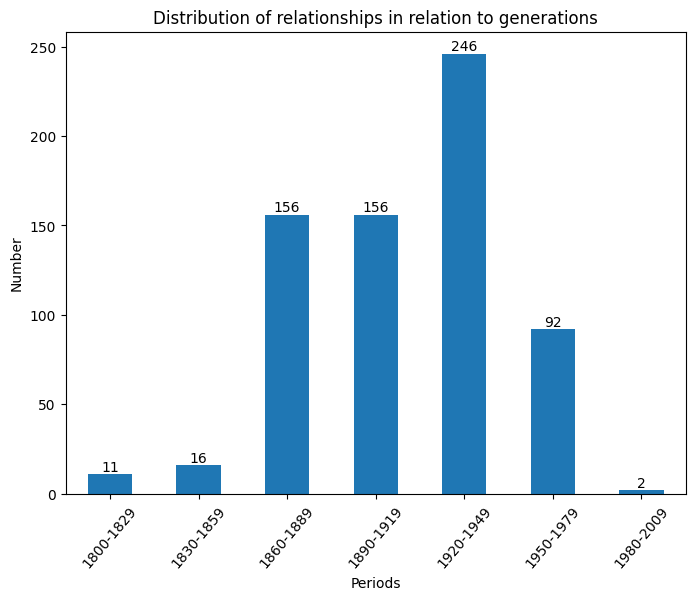

In [16]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [17]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
employment    357
membership    322
dtype: int64


In [18]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

      periods    relaType  size
0   1800-1829  membership    11
1   1830-1859  employment     5
2   1830-1859  membership    11
3   1860-1889  employment    53
4   1860-1889  membership   103
5   1890-1919  employment    79
6   1890-1919  membership    77
7   1920-1949  employment   162
8   1920-1949  membership    84
9   1950-1979  employment    57
10  1950-1979  membership    35
11  1980-2009  employment     1
12  1980-2009  membership     1


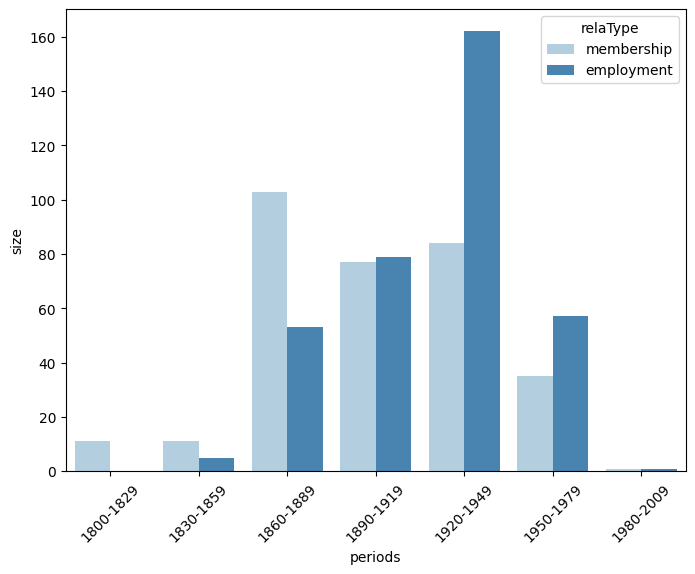

In [19]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [20]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


679
[['educational institution', 'inns of court', 'university building'],
 ['charitable organization', 'club'],
 ['public educational institution of the united states', 'university campus']]


In [21]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q2154954,Vegetarian Society,2,charitable organization | club,1860-1889,"[charitable organization, club]"
5,http://www.wikidata.org/entity/Q105301557,Sofia Spångberg,1898,membership,http://www.wikidata.org/entity/Q105317493,Q105317493,1,voluntary association,1890-1919,[voluntary association]
10,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q20266330,Frederick William University Berlin,1,university,1860-1889,[university]


#### Organisations' types distribution

In [22]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
organization                                                                                                     44
international organization | non-governmental organization | nonprofit organization | women's organization       26
international organization | peace organization | women's organization                                           22
university                                                                                                       17
academic publisher | learned society | nonprofit organization                                                    15
colonial colleges | private not-for-profit educational institution | private university | research university    13
intergovernmental organization | international organization                                                      10
musical group                                                                                                    10
political organization                                         

#### Save dataframe to CSV

In [23]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [24]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,organization,44,1
1,international organization | non-governmental ...,26,4
2,international organization | peace organizatio...,22,3
3,university,17,1
4,academic publisher | learned society | nonprof...,15,3
5,colonial colleges | private not-for-profit edu...,13,4
6,intergovernmental organization | international...,10,2
7,musical group,10,1
8,political organization,9,1
9,private not-for-profit educational institution...,8,2


In [25]:
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [26]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q1233784,Inner Temple,3,educational institution | inns of court | univ...,1860-1889,"[educational institution, inns of court, unive..."


In [27]:
def code_organisation_main_type(x):
    x = x.lower()
    
    if 'colonial colleges' in x \
        or 'private not-for-profit educational institution' in x \
        or 'private university' in x \
        or 'university' in x \
        or 'research university' in x:
        return 'university'
    
    elif 'academic publisher' in x \
        or 'learned society' in x:
        return 'learned society'
    
    elif 'international organization' in x \
        or 'intergovernmental organization' in x:
        return 'international organisation'
    
    elif 'non-governmental organization' in x \
        or 'peace organization' in x \
        or "women's organization" in x:
        return 'non-governmental organisation'
    
    elif 'political organization' in x:
        return 'political organisation'
    
    elif 'musical group' in x:
        return 'musical group'
    
    else:
        return 'generic organisation'
 

In [28]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q105583600,Ken Weller,1936,membership,http://www.wikidata.org/entity/Q7577135,Spies for Peace,1,group of humans,1920-1949,[group of humans],generic organisation
8,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q152087,Humboldt-Universität zu Berlin,4,comprehensive university | open-access publish...,1860-1889,"[comprehensive university, open-access publish...",university
9,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q168426,University of Münster,3,comprehensive university | local internet regi...,1860-1889,"[comprehensive university, local internet regi...",university


In [29]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
0,generic organisation,275
6,university,229
1,international organisation,72
4,non-governmental organisation,40
2,learned society,36
5,political organisation,14
3,musical group,13


In [30]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
200,musical group,musical group,10,1
268,political organization,political organisation,9,1
277,private not-for-profit educational institution...,university,8,2


# Create graphs

In [31]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
employment    357
membership    322
dtype: int64


### Prepare the dataframe

In [32]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

679


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [33]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
395,http://www.wikidata.org/entity/Q689768,Women's International League for Peace and Fre...,international organization | non-governmental ...,international organisation,26
371,http://www.wikidata.org/entity/Q60564688,International Committee of Women for Permanent...,international organization | peace organizatio...,international organisation,19
293,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,15
82,http://www.wikidata.org/entity/Q13371,Harvard University,colonial colleges | private not-for-profit edu...,university,13
317,http://www.wikidata.org/entity/Q49088,Columbia University,colonial colleges | organization | private not...,university,8
378,http://www.wikidata.org/entity/Q623009,National Woman's Party,organization | political party,generic organisation,7
15,http://www.wikidata.org/entity/Q1065,United Nations,intergovernmental organization | international...,international organisation,7
400,http://www.wikidata.org/entity/Q7045639,Nobel Women's Initiative,advocacy group | international organization,international organisation,6
292,http://www.wikidata.org/entity/Q463281,American Academy of Arts and Letters,academy of sciences | award,generic organisation,6
279,http://www.wikidata.org/entity/Q41506,Stanford University,open-access publisher | private not-for-profit...,university,6


In [34]:
### Save list of organisations as CSV
csv_file='data/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [35]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
404,http://www.wikidata.org/entity/Q529564,Association of German Engineers,generic organisation,1800-1829,1
492,http://www.wikidata.org/entity/Q76391871,Société pour l'amélioration du sort de la femm...,generic organisation,1800-1829,1
362,http://www.wikidata.org/entity/Q4903078,Bible Christian Church,generic organisation,1800-1829,1
183,http://www.wikidata.org/entity/Q188771,French Academy of Sciences,generic organisation,1800-1829,1
248,http://www.wikidata.org/entity/Q2583804,American Anti-Imperialist League,political organisation,1800-1829,1


#### Group by period and relationship type

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [36]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
430,http://www.wikidata.org/entity/Q60564688,International Committee of Women for Permanent...,international organisation,membership,1860-1889,17
461,http://www.wikidata.org/entity/Q689768,Women's International League for Peace and Fre...,international organisation,membership,1860-1889,16
340,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1920-1949,10
462,http://www.wikidata.org/entity/Q689768,Women's International League for Peace and Fre...,international organisation,membership,1890-1919,6
93,http://www.wikidata.org/entity/Q13371,Harvard University,university,employment,1920-1949,6


In [37]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='data/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

50


,periods,relaType,orgMainType,period_members_number
3,1830-1859,employment,generic organisation,2
4,1830-1859,employment,university,3
8,1860-1889,employment,generic organisation,16
9,1860-1889,employment,international organisation,3
10,1860-1889,employment,non-governmental organisation,4
11,1860-1889,employment,university,30
18,1890-1919,employment,generic organisation,25
19,1890-1919,employment,international organisation,3
20,1890-1919,employment,non-governmental organisation,3
21,1890-1919,employment,university,48


In [38]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

12


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [39]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [40]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [41]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,employment,membership,Total
orgMainType,,,
generic organisation,102,173,275
international organisation,11,61,72
learned society,0,36,36
musical group,0,13,13
non-governmental organisation,15,25,40
political organisation,1,13,14
university,228,1,229
Total,357,322,679


In [42]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,employment,membership
orgMainType,,
generic organisation,102,173
international organisation,11,61
learned society,0,36
musical group,0,13
non-governmental organisation,15,25
political organisation,1,13
university,228,1


In [43]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 338.95 , dof : 6
p-value : 3.627845453123343e-70
phi2 = inertie (variance totale) : 0.4991941046497402
Cramer:  0.7065366973128432


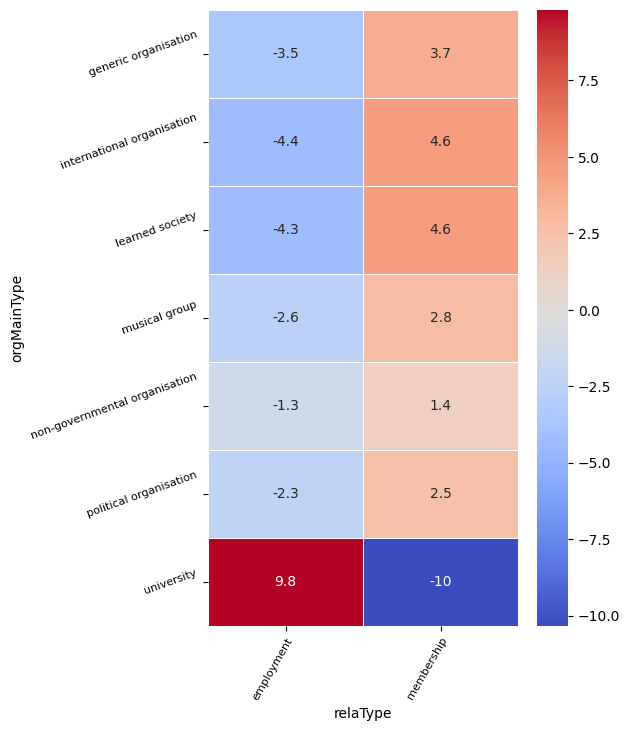

In [44]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))